In [8]:
from datetime import date
import csv
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from math import ceil
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.path import Path

In [3]:
def plotNames (info,shape):
    xc, yc = zip(*shape)
    plt.text((max(xc)+min(xc))/2,(max(yc)+min(yc))/2,info['MD_NAME'],ha='center',va='center', zorder=5, fontsize=10)



2018-12-12


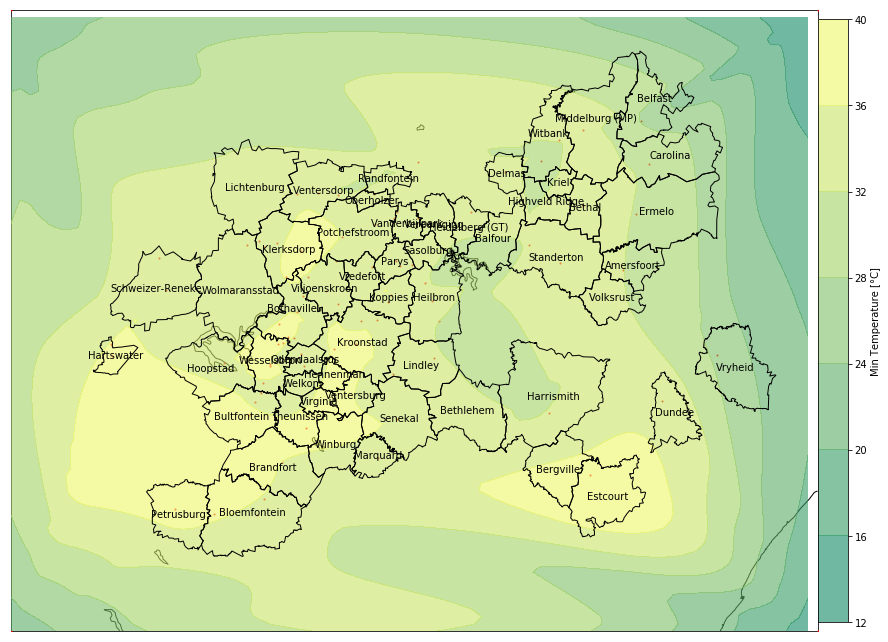

In [15]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)


df1 = pd.read_csv('data/temp20181030.csv', na_values=['NaN'], sep=',')
norm = Normalize()

measurement = 'tempmax'

extremes = [[-30.163374,23.785686,21.6],[-24.69508,23.785686,21.3],[-24.69508,31.79263,11.7],[-30.163374,31.79263,13.3]]

df2 = pd.DataFrame(extremes, columns=['lat','lon', measurement])
data = df1.append(df2)

#mapextent
lllon = data['lon'].min()
lllat = data['lat'].min()
urlon = data['lon'].max()
urlat = data['lat'].max()

#Generate Basemap
pad = 0  # padding around map extents
m = Basemap(
    projection = 'merc', \
    llcrnrlon = lllon - pad, \
    llcrnrlat = lllat - pad, \
    urcrnrlon = urlon + pad, \
    urcrnrlat = urlat + pad, \
    resolution='h', \
    ax=ax)

m.drawcoastlines()
m.readshapefile('data/grense', 'grense',zorder=10,linewidth=1, drawbounds=True)

for info, shape in zip(m.grense_info, m.grense):
    plotNames(info,shape)


# transform lon / lat coordinates to map projection
data['projected_lon'], data['projected_lat'] = m(*(data.lon.values, data.lat.values))

#Plot station coordinates on map
m.scatter(data['projected_lon'], data['projected_lat'], marker = 'o', color='r', zorder=5, s=1)

#Interpolate weather data to meshgrid
x, y, z = data['projected_lon'].values, data['projected_lat'].values, data[measurement].values
xi = np.arange(0, max(x), abs((abs(max(x))-abs(min(x))))/len(x))
yi = np.arange(0, max(y), abs((abs(max(y))-abs(min(y))))/len(y))
xi,yi = np.meshgrid(xi,yi)

zi = griddata((x,y),z,(xi,yi),method='cubic')

cs = m.contourf(xi, yi, zi, zorder=5, alpha=0.6, cmap='summer')
#plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=12, colors='k')

#Contour legend
#proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

#plt.legend(proxy, ["range(2-3)", "range(3-4)", "range(4-6)"])

cbar = plt.colorbar(cs, fraction=0.036, pad=0)
cbar.ax.set_ylabel('Min Temperature [\N{DEGREE SIGN}C]')
# Add the contour line levels to the colorbar

today = str(date.today())
#Save plot as image
plt.savefig(today+'-'+measurement)